# Self Attention - Simple but thorough explanation with real life examples

## Attention module architecture - A quick overview

When looking at transformers, the following architecture is always shown:

![alt text](https://miro.medium.com/v2/resize:fit:850/1*nhwzi5yDdkI70uhx2KH1Dw.png "Title")

In this image, we should pay attention to the zoom ins first. It all starts with the 3 Q, K, V matrices. 
Let's remember our goal with Self Attention - We want to find out which words in our input attend to which other words in our input. 

For example, in these sentences:
- The fox jumped over the fence as it was being chased
- The fox jumped over the fence as it was low 

The word "it" refers to different words, although the structure has not changed much. How do we know to which word the word "it" **attends** to?


*(I'm skipping the history part. Generally this used to be solved with LSTMs and before that recuurence models (aka RNNs))*

## Input Embedding
Note the inputs to the attention mechanism. The inputs (read: a bunch of words) are *embedded and encoded* into vectors. This encoding includes:
  1. Converting words into numbers using their context. This conversion takes into account word similarity and "closeness". Words closer together in meaning will have closer values.
  2. These number vectors are then added to a positional index representing the position in the input text. This position isn't really "the 3rd word from the start" but actually has quite a complex calculation. Smart people did these, we are relying on them.

All of these vector are not really vectors of numbers as well, but instead they are a **Matrix** X with [N, D] dimensions. N being the number of tokens (words or subwords) and D being the "dimensionally of the data". Bullocks on that last phrase which everyone likes to use and means nothing unless you really understand what's going on. All it means is that the input embedding and encoding has D numbers representing each token, word, subword, whatever. D is constant though - For ALL input.##

To recap, input is X ~ [N rows over D columns]

Okay, enough theory. Let's see this happening live. We'll start by looking at the word embeddings. Our data will base on the sentence *"The fox jumped over the fence as it was low"*

In [91]:
from transformers import BertTokenizer, BertModel
import torch

text = "The fox jumped over the fence as it was low"

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode text
encoded_input = tokenizer(text, return_tensors='pt')
print(encoded_input['input_ids'].shape)
print(encoded_input['input_ids'])

torch.Size([1, 12])
tensor([[ 101, 1996, 4419, 5598, 2058, 1996, 8638, 2004, 2009, 2001, 2659,  102]])


We have a **12** tokens vector from a **10** word sentences. Why? In this case it's simple - 101 is "CLS" (stands for Classification), which represents the start of the sentence in this case, and 102 is "SEP" (stands for Seperator), which represents the end of the sentence. 

Now let's look at how these tokens passed through embedding. In order to do so we'll run BERT, but take only the first token embeddings

Embeddings Shape: torch.Size([1, 12, 768])
For word "it": torch.Size([768])


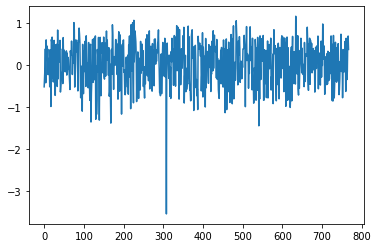

In [92]:
# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model to evaluation mode to deactivate the DropOut modules
model.eval()

# Forward pass to the embedding layer only
with torch.no_grad():
    # Extract embeddings
    embeddings = model.embeddings(encoded_input['input_ids'])

print("Embeddings Shape:", embeddings.shape)

probed_word = "it"
word_index = text.split(" ").index(probed_word) + 1  # This index might change based on tokenization
print(f'For word "{probed_word}": {embeddings[0, word_index, :].shape}')

import matplotlib.pyplot as plot
plot.figure()
plot.plot(embeddings[0, word_index, :])
plot.show()


We see that D here is 768 - There are 768 dimensions to every word (or token). This is our X.

Now for the interesting part, let's look at our attention matrices:

# Q, K, V matrices

Q, K, V are matrices that formed by multiplying a **trained** set of weights $W_Q, W_K, W_v$ with input X. The weights are learned while training but are static afterwards - All that is changing is the input.

Back to our original example:
*"The fox jumped over the fence as it was low"*

- Q (Query): Represents the target word ("jumped") in a way that we can query the sentence for relevant context.
- K (Key): Represents all words in the context of being matched to the query, to see how relevant each is to "jumped".
- V (Value): Contains the actual information of each word, which is used if the word is deemed relevant to the query.

Read these definitions a few times. Their meaning is important. Also, we'll touch dimensions later, but these are interesting.

Now let's have the actual calculation:

- Query (Q) for "jumped": Represents "jumped" when we are querying the sentence to find relevant context for "jumped". Let's say it transforms to  [0.6, 0.2, ...]
- Key (K) for each word: Represents each word when we are trying to match the query to the sentence. For "fox", it might be [0.5, 0.4, ...], indicating how "fox" is contextually relevant to "jumped".
- ~~Value (V) - I'm going to ignore Value matrix for now, as it's job is really technical and doesn't really represent the attention concept in my opinion.~~

Let's look at how it actually works.

*[Note - These matrices aren't really exposed externally, I had to "monkeypatch" them out manually. Feel free to ignore the internals here]*

In [93]:
import torch
from transformers import AutoTokenizer, AutoModel


# Function to be called by the hook
def hook_extract_qkv(module, input, output):
    # Save the Q, K, V matrices to the module
    # The module's `self_attention` attribute has the Q, K, V matrices
    # as part of its last attention calculation
    module.q_matrix = module.attention.self.query(input[0])
    module.k_matrix = module.attention.self.key(input[0])
    module.v_matrix = module.attention.self.value(input[0])

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Attach the hook to the first layer's self-attention mechanism
hook = model.encoder.layer[0].register_forward_hook(hook_extract_qkv)

# Encode some text and run it through the model
encoded_input = tokenizer(text, return_tensors='pt')

# No need to compute gradients
with torch.no_grad():
    model(**encoded_input)

# The hook has now saved Q, K, V matrices in the first layer
q_matrix = model.encoder.layer[0].q_matrix
k_matrix = model.encoder.layer[0].k_matrix
v_matrix = model.encoder.layer[0].v_matrix

print("Q matrix shape:", q_matrix.shape)
print("K matrix shape:", k_matrix.shape)
print("V matrix shape:", v_matrix.shape)

hook.remove()

Q matrix shape: torch.Size([1, 12, 768])
K matrix shape: torch.Size([1, 12, 768])
V matrix shape: torch.Size([1, 12, 768])


So the shapes make sense - They are the same sizes at out input matrix. Remember that the matrices are defined as 
$ Q = X W_Q $

It does make sense that the dimensionallity of the attention matrices will keep the embedding dimensionallity. 

### A note about multihead attention
We've seen that the input has quite a large dimensionallity - 768. Not that large, but for large input (think a 1000 words) it could be time consuming to use. What we often do is to calculate the attention for the embedding dimensions *in parallel* with multiple "heads" - Each head using only a subset of dimensions.
That being said, what is happening here is that we're viewing the Q, K, V post all attention head aggregation - We're viewing the output of a layer - The multi-head attention layer. We're looking at all the heads together.
~

You might wonder if we can learn anything from these matrices values. Let's take a look:

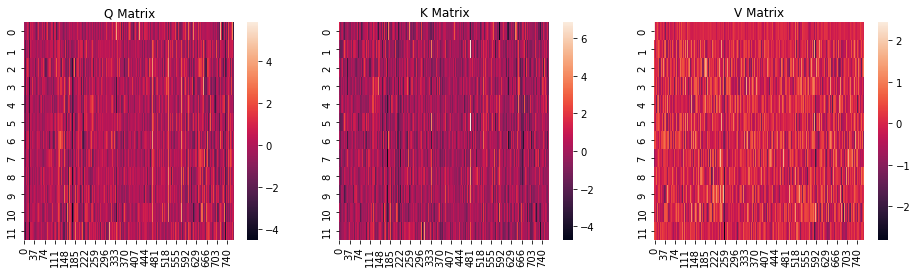

In [94]:
# Visualize the matricex
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

plt.figure(figsize=(16, 4))
plot.subplot(1, 3, 1)
ax = sns.heatmap(q_matrix[0, :, :])
plot.title('Q Matrix')
plot.subplot(1, 3, 2)
ax = sns.heatmap(k_matrix[0, :, :])
plot.title('K Matrix')
plot.subplot(1, 3, 3)
ax = sns.heatmap(v_matrix[0, :, :])
plot.title('V Matrix')
plt.show()

With the embedding and everything - It's kinda hard to understand anything in here. Luckily, we're not looking at the actual attention yet.

Attention is really more about $ Q*K^T $, which should be in size we can grasp.
We'll also add in the scaling + softmax, as defined in the architecture

Scaled Attention Scores Shape: torch.Size([1, 12, 12])


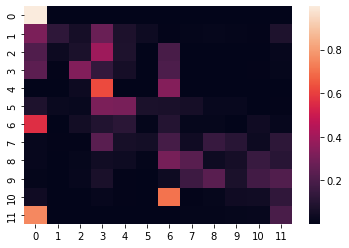

In [95]:
import torch.nn.functional

# Calculate Q * K^T
attention_scores = torch.matmul(q_matrix, k_matrix.transpose(-1, -2))

# Apply scaling
d_k = q_matrix.size(-1)  # The size of the key dimension
scaled_attention_scores = attention_scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float))

attention_weights = torch.nn.functional.softmax(scaled_attention_scores, dim=-1)

print("Scaled Attention Scores Shape:", attention_weights.shape)

plt.figure()
ax = sns.heatmap(attention_weights[0, :, :])
plt.show()

Oh wait, we're still on 12 tokens - SEP and CLS aren't interesting for our context, let's remove them and stretch the colors to be stronger:

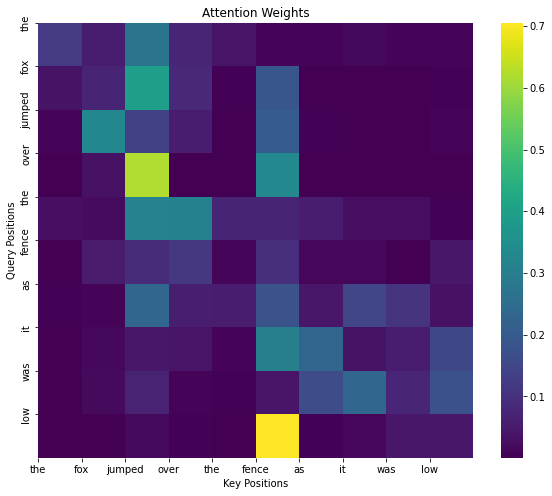

In [96]:
attention_matrix = attention_weights[0, 1:-1, 1:-1].detach().numpy()

tokens = tokenizer.tokenize(text)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(attention_matrix, annot=False, cmap='viridis', square=True)
ax.set_xticks(range(len(tokens)))
ax.set_yticks(range(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_yticklabels(tokens)
ax.set_title('Attention Weights')
ax.set_xlabel('Key Positions')
ax.set_ylabel('Query Positions')
plt.show()

OKAY - Finally something good. 
Remember our text: "The fox jumped over the fence as it was low"

There are many interesting things in this graph:
1. Note how "over" attends strongly with "jumped" and "fence"
2. "low" attends very strongly to "fence" as well
3. And last but not least - "it" doesn't attend the fox at all. "it" attends mostly "fence"

## What about the Value matrix?

V matrix is here to bring the attention matrix back to the embedding space (from token space), also adding weights from its own. I'll show it here, but unless you can read embeddings, don't expect anything too explainable.

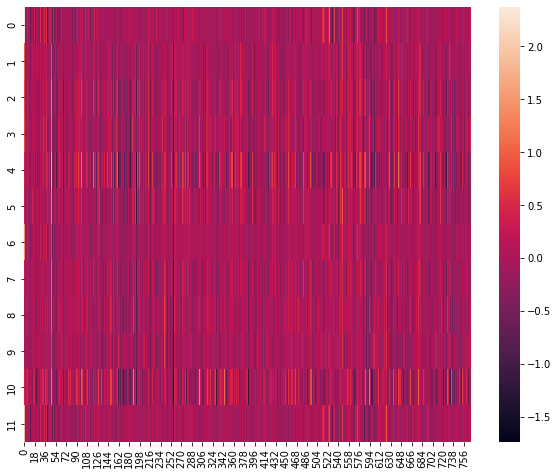

In [100]:
attention_output = torch.matmul(attention_weights, v_matrix)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(attention_output[0, :, :])
plt.show()

## What about "Masked" attention?
Masked attention is a variant of the attention mechanism where certain positions in the input sequence are intentionally masked or hidden during the computation of attention weights. This is achieved by setting the attention scores for these positions to a very large negative value (before applying the softmax function), effectively making their contribution to the softmax output negligible.

ChatGPT says that masked attention is used in the following contexts:

- Autoregressive Language Models: In models designed for generating text (like GPT), masked attention ensures that a token can only attend to previously generated tokens in the sequence. This enforces a left-to-right information flow, preventing the model from "seeing the future" — that is, using information from tokens that haven't been generated yet.- 
Training Objective: In models like BERT, which use a masked language model (MLM) objective, random tokens in the input sequence are masked, and the model is trained to predict these masked tokens based only on their context. Masked attention in this context prevents the model from cheating by using the masked token itself in its prediction, focusing instead on the surrounding tokenr?

### Bonus - Bert visualization

BERT has a built in attention visualization tool we could use. Use at your own risk

In [88]:
from bertviz.transformers_neuron_view import BertModel
import bertviz.neuron_view
import bertviz.model_view
import bertviz.head_view
from transformers import AutoModel, utils

import numpy as np

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
inputs = tokenizer.encode(text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights among other things
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

bertviz.head_view(attention, tokens)
# bertviz.neuron_view.show(model, "bert", tokenizer, text)
bertviz.model_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>